### 栅格数据与矢量数据的相互转换


In [1]:
from osgeo import gdal
from osgeo import osr, ogr
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
path_img = 'data/Section_5/rsimg_chenggon_mndwi_thre025.tif'
path_img2polygon = 'data/Section_5/rsimg_chenggon_mndwi_polygon.shp'
dset = gdal.Open(path_img)
img_array = dset.ReadAsArray()
print(img_array.shape)


(1555, 1573)


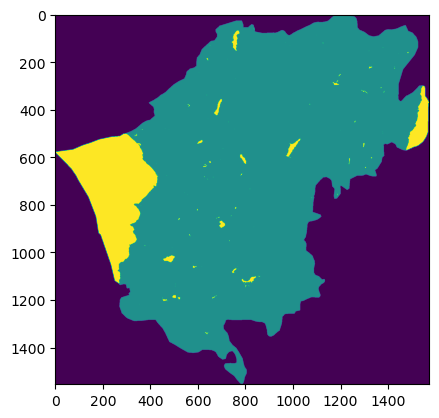

In [3]:
plt.imshow(img_array)


### 主要函数：gdal.Polygonize()
https://gdal.org/api/python/osgeo.gdal.html   
#### 用法：gdal.Polygonize(srcBand, maskBand, outLayer, iPixValField)   
其中主要参数srcBand为输入数据波段，maskBand为掩膜波段（只对掩膜区域处理），outLayer为矢量化后的矢量图层，iPixValField为需要将DN值写入矢量字段的索引。


In [15]:
DN_vec = [1]
dset = gdal.Open(path_img)       # 读取路径中的栅格数据
mndwi = dset.GetRasterBand(1)    # 这个波段就是最后想要转为矢量的波段，如果是单波段数据的话那就都是1
prj = osr.SpatialReference()
prj.ImportFromWkt(dset.GetProjection())  # 读取栅格数据的投影信息，用来为后面生成的矢量做准备
drv = ogr.GetDriverByName("ESRI Shapefile")
polygon = drv.CreateDataSource(path_img2polygon)  # 创建一个目标文件
poly_layer = polygon.CreateLayer('mndwi_polygon', srs=prj, geom_type=ogr.wkbMultiPolygon)  # 对shp文件创建一个图层，定义为多个面类
newField = ogr.FieldDefn('DN', ogr.OFTInteger)  # 给目标shp文件添加一个字段，用来存储原始栅格的pixel value
poly_layer.CreateField(newField)
gdal.Polygonize(srcBand=mndwi, maskBand=None, outLayer=poly_layer, iPixValField=0)   # 核心函数，执行的就是栅格转矢量操作
### 删除特定DN值类别要素
for fea in poly_layer:
    DN_value = fea.GetField('DN')
    if DN_value not in DN_vec:
        poly_layer.DeleteFeature(fea.GetFID())

polygon.SyncToDisk()
Polygon = None


### 快捷方式：gdal_polygonize.py
参考：  
1 https://gdal.org/programs/gdal_polygonize.html）  

In [23]:
### 具有局限性，无法对特定DN值的像素进行矢量化。
!gdal_polygonize.py -nomask $path_img $path_img2polygon



Creating output data/Section_5/rsimg_chenggon_mndwi_polygon.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
